In [1]:
import pandas as pd
from collections import defaultdict
import warnings
import visualize
import neat
import multiprocessing
import os
import matplotlib.pyplot as plt

import numpy as np

from sklearn.datasets import load_digits
digits = load_digits()

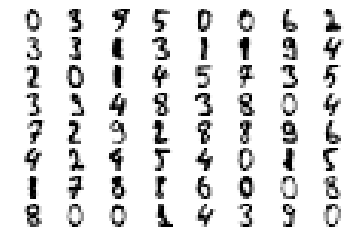

In [2]:
from random import randint

for i in range(64):
    ax = plt.subplot(8, 8, i+1)
    ax.axis('off')
    plt.imshow(digits.images[randint(0, digits.images.shape[0])], cmap='Greys')
plt.show()

In [3]:
X = digits.images.reshape(digits.images.shape[0], digits.images.shape[1] * digits.images.shape[2])
y = digits.target

In [4]:
def softmax(x, axis=1):
    # 计算每行的最大值
    row_max = x.max(axis=axis)
 
    # 每行元素都需要减去对应的最大值，否则求exp(x)会溢出，导致inf情况
    row_max=row_max.reshape(-1, 1)
    x = x - row_max
 
    # 计算e的指数次幂
    x_exp = np.exp(x)
    x_sum = np.sum(x_exp, axis=axis, keepdims=True)
    s = x_exp / x_sum
    return s

In [5]:
def eval_genomes(genomes, config):
    for genome_id, genome in genomes:
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        
        outputs = []
        for xi in x_inputs:
            output = net.activate(xi)
            outputs.append(output)
        
        
        px_outputs = softmax(np.array(outputs).reshape(samplesize, number_of_classification), axis=1)
        # the index of maximum in each line
        pred_outputs = np.argmax(px_outputs, axis = 1)
        # replace index to real number, from higher number to lower number!!
        for i in range(number_of_classification):
            index = number_of_classification - i - 1
            pred_outputs[pred_outputs==index] = numbers[index]
        
        real_outputs = np.array(x_outputs).reshape(samplesize,)
        
        acc = np.sum(pred_outputs == real_outputs)/samplesize

        genome.fitness = acc

In [6]:
numbers = [*range(10)] # number 2 > number 1
number_of_classification = len(numbers)
number_of_sampling = 80
##？？ 删除number of sampling


list_y = y.tolist()
digits_indexes = []
for digit in numbers:
    li = [i for i in range(len(list_y)) if list_y[i] == digit]
    digits_indexes.extend(li[:number_of_sampling])

samplesize = X[digits_indexes].shape[0]
x_inputs =[tuple(c) for c in X[digits_indexes].tolist()]
x_outputs = [tuple(c) for c in y[digits_indexes].reshape(samplesize,1).tolist()]

In [8]:
winner_list = []
stats_list = []
for i in range(2,3):
    numbers = [*range(i)] # number 2 > number 1
    number_of_classification = len(numbers)
    number_of_sampling = 80

    list_y = y.tolist()
    digits_indexes = []
    for digit in numbers:
        li = [i for i in range(len(list_y)) if list_y[i] == digit]
        digits_indexes.extend(li[:number_of_sampling])

    samplesize = X[digits_indexes].shape[0]
    x_inputs =[tuple(c) for c in X[digits_indexes].tolist()]
    x_outputs = [tuple(c) for c in y[digits_indexes].reshape(samplesize,1).tolist()]

    def run(config_file):
        # Load configuration.
        config = neat.Config(
            neat.DefaultGenome,
            neat.DefaultReproduction,
            neat.DefaultSpeciesSet,
            neat.DefaultStagnation,
            config_file,
        )

        # Create the population, which is the top-level object for a NEAT run.
        p = neat.Population(config)

        # add a stdout reporter to show progress in the terminal
        reporter = neat.StdOutReporter(False)
        p.add_reporter(reporter)
        stats = neat.StatisticsReporter()
        p.add_reporter(stats)
        #checkpointer = neat.Checkpointer(100)
        #p.add_reporter(checkpointer)
        # Run for up to 300 generations.
        winner = p.run(eval_genomes, 1500)

        return [stats, winner]


    samplesize = len(x_outputs)

    local_dir = os.getcwd()
    config_path = os.path.join(local_dir, "config-feedforward-mnist"+str(number_of_classification))
    [stats, winner] = run(config_path)
    winner_list.append(winner)
    stats_list.append(stats)


 ****** Running generation 0 ****** 

Population's average fitness: 0.50266 stdev: 0.15991
Best fitness: 0.96875 - size: (2, 13) - species 3 - id 144
Average adjusted fitness: 0.490
Mean genetic distance 2.872, standard deviation 0.477
Population of 200 members in 19 species
Total extinctions: 0
Generation time: 0.731 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.58759 stdev: 0.18201
Best fitness: 0.98125 - size: (2, 14) - species 4 - id 349
Average adjusted fitness: 0.529
Mean genetic distance 2.941, standard deviation 0.473
Population of 201 members in 27 species
Total extinctions: 0
Generation time: 0.735 sec (0.733 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.64646 stdev: 0.18861
Best fitness: 0.99375 - size: (2, 14) - species 26 - id 503
Average adjusted fitness: 0.538
Mean genetic distance 2.993, standard deviation 0.477
Population of 199 members in 31 species
Total extinctions: 0
Generation time: 0.762 sec (0.743 a

In [19]:
winner_list

In [20]:
#visualize.plot_stats(stats, ylog=False, view=False)

In [21]:
best_fitness_list = []
avg_fitness_list = []
stdev_fitness_list = []

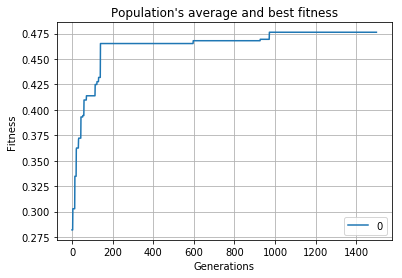

In [22]:
best_fitness_list = []

for i in range(1):
    statistics = stats_list[i]

    generation = range(len(statistics.most_fit_genomes))
    best_fitness = [c.fitness for c in statistics.most_fit_genomes]
    avg_fitness = np.array(statistics.get_fitness_mean())
    stdev_fitness = np.array(statistics.get_fitness_stdev())
    
    best_fitness_list.append(best_fitness)
    avg_fitness_list.append(avg_fitness)
    stdev_fitness_list.append(stdev_fitness)

    #plt.plot(generation, avg_fitness, "b-", label="average")
    #plt.plot(generation, avg_fitness - stdev_fitness, "g-.", label="-1 sd")
    #plt.plot(generation, avg_fitness + stdev_fitness, "g-.", label="+1 sd")
    
    plt.plot(generation, best_fitness, label=i)

plt.title("Population's average and best fitness")
plt.xlabel("Generations")
plt.ylabel("Fitness")
plt.grid()
plt.legend(loc="best")
plt.show()


In [46]:
np.save("fitness3.npy",np.array(best_fitness_list[:]))
np.save("avg3.npy",np.array(avg_fitness_list[:]))
np.save("stdev3.npy",np.array(stdev_fitness_list[:]))

In [4]:
# 十次之后2-10分类的准确率
num_list = [0.992, 0.8, 0.71, 0.538, 0.47167, 0.44143, 0.37250, 0.30333, 0.29800]
name_list = ['2','3','4','5','6','7','8','9','10']
plt.bar(range(len(num_list)), num_list, tick_label = name_list, alpha = 0.6)
plt.ylim((0, 1))

for x, y in zip(range(len(num_list)), num_list):
    # ha: horizontal alignment
    # va: vertical alignment
    plt.text(x , y - 0.06, '%.3f' % y, ha='center', va='bottom')

plt.xlabel('Number of classes')
plt.ylabel('Accuracy')
#plt.show()
plt.savefig("accuracy.eps")

In [52]:
a = np.load("fitness.npy")
b = np.load("avg.npy")
c = np.load("stdev.npy")

In [53]:
a1 = np.load("fitness1.npy")
b1 = np.load("avg1.npy")
c1 = np.load("stdev1.npy")

In [54]:
a2 = np.load("fitness2.npy")
b2 = np.load("avg2.npy")
c2 = np.load("stdev2.npy")

In [57]:
a2

array([[0.28194444, 0.28194444, 0.28194444, ..., 0.47638889, 0.47638889,
        0.47638889]])

In [42]:
list_a = [a,a1,a2]

In [44]:
np.array(list_a)

array([array([0.61666667, 0.8       , 0.8       , ..., 0.5921875 , 0.5921875 ,
       0.5921875 ]),
       array([[0.2515625, 0.2859375, 0.340625 , ..., 0.5921875, 0.5921875,
        0.5921875]]),
       array([], dtype=float64)], dtype=object)

In [45]:
a2

array([], dtype=float64)